
[이상치 탐지 (Anomaly Detection)]에 대한 상세 강의 자료와 실습 노트북이다.

이 시간의 핵심은 "단순히 높은 수치를 찾는 것이 아니라, '평소와 다른' 움직임을 찾아내는 것"이다. 이는 환자 모니터링 시스템(Patient Monitoring System)의 알람 원리와 직결된다.

---

# 📘 이상치 탐지: 위험 신호 골라내기

## 1. 헬스케어에서의 이상치(Anomaly)란?
*   정의: 예상되는 정상적인 패턴에서 벗어난 데이터 포인트이다.
*   두 가지 얼굴:
    1.  부정적 이상치 (Risk): 심정지(Cardiac Arrest), 낙상, 패혈증 쇼크 등 환자의 상태가 급격히 악화되는 신호.
    2.  긍정적 이상치 (Discovery): 신약 투여 후 암세포가 예상보다 급격히 줄어드는 기적적인 반응.
    3.  오류 (Artifact): 센서 탈착, 기계 고장 등으로 인한 가짜 신호. (데이터 분석가는 이것을 걸러내고 위의 두 가지만 남겨야 한다.)

## 2. 고정 임계값(Static) vs 동적 임계값(Dynamic)
환자의 심박수가 120이면 위험한 것일까?
*   고정 임계값 방식: "100 넘으면 무조건 경보 울려!"
    *   *문제점:* 평소 심박수가 60인 환자에게 90은 매우 높은 수치지만, 경보가 안 울린다(False Negative). 반대로 운동 중인 환자는 110이 정상이지만 경보가 울린다(False Positive).
*   동적 임계값 방식: "평소(최근 1시간) 흐름보다 급격히 튀면 경보 울려!"
    *   환자의 '현재 상태(Baseline)'에 맞춰 기준선이 같이 움직인다. 시계열 분석에서는 이 방식이 훨씬 효과적이다.

## 3. 통계적 탐지 기법: 3-Sigma Rule (Z-score)
데이터가 정규분포를 따른다고 가정할 때, 평균에서 표준편차($\sigma$)의 3배 이상 떨어진 값은 전체의 0.3%에 불과하다. 즉, 거의 일어나지 않는 희귀한 사건이다.
*   볼린저 밴드 (Bollinger Bands): 주식 시장에서 쓰이는 기법이지만 생체 신호 감시에도 유용하다.
    *   중심선: 이동 평균선 (추세)
    *   상한선: 이동 평균 + ($K$ $\times$ 이동 표준편차)
    *   하한선: 이동 평균 - ($K$ $\times$ 이동 표준편차)
    *   데이터가 이 밴드(상한~하한)를 벗어나면 이상치로 간주한다.

## 4. 경보 피로 (Alarm Fatigue)
병원 현장에서 가장 큰 문제 중 하나이다. 너무 민감하게 이상치를 잡으면(False Positive), 의료진이 계속 울리는 알람에 무감각해져서 진짜 위급 환자를 놓치게 된다. 따라서 적절한 $K$값(민감도 조절)을 찾는 것이 데이터 분석가의 역할이다.

---
---

# 💻 볼린저 밴드를 이용한 환자 감시

이 노트북에서는 정상적인 생체 리듬을 가진 데이터에 갑작스러운 이상(Spike)을 심어놓고, 이동 평균과 표준편차를 이용한 동적 임계값으로 이를 잡아내는 실습을 진행한다.

### 1. 환경 설정 및 데이터 생성 (정상 + 이상 심기)
평소에는 일정한 리듬(Sine wave)을 타다가, 특정 시점에 값이 튀는 데이터를 만든다.



데이터 미리보기:


,Signal
0,-0.020347
1,0.078186
2,0.136538
3,0.321230
4,0.791151


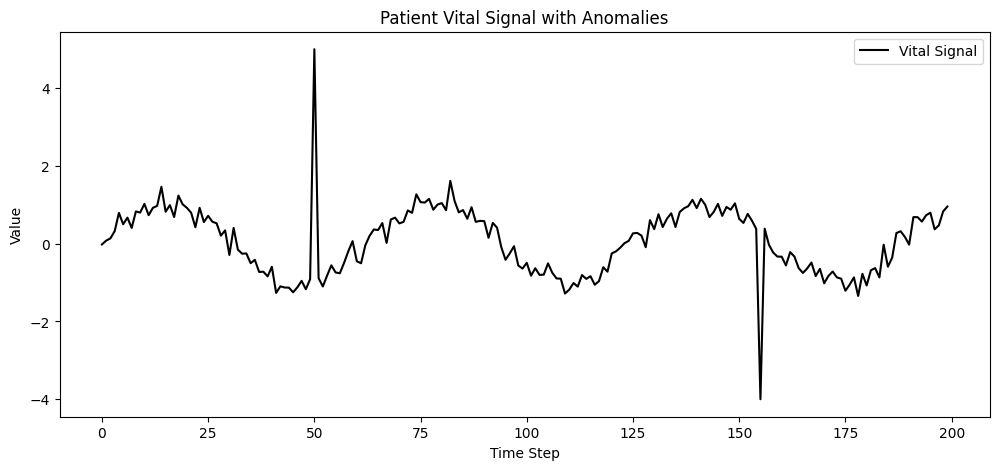

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 시간축 생성 (200개의 데이터 포인트)
time_steps = np.arange(200)

# 2. 정상 패턴 (Baseline): 사인파(주기적 리듬) + 약간의 노이즈
# np.sin(time_steps * 0.1): 주기적 파동
# np.random.normal(0, 0.2, 200): 작은 잡음
baseline = np.sin(time_steps * 0.1) + np.random.normal(0, 0.2, 200)

# 3. 이상치(Anomaly) 주입
# 특정 시점(150번째)에 심각한 쇼크(값 +5) 발생 가정
baseline[50] = 5.0   # 튀는 값 (Positive Spike)
baseline[155] = -4.0 # 떨어지는 값 (Negative Spike)

# 데이터프레임 생성
df = pd.DataFrame({'Signal': baseline}, index=time_steps)

print("데이터 미리보기:")
display(df.head())

# 시각화: 어디가 이상한지 눈으로 확인
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Signal'], label='Vital Signal', color='black')
plt.title("Patient Vital Signal with Anomalies")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

### 2. 동적 임계값 계산 (Bollinger Bands)
이전 시간(4교시)에 배운 Rolling 기능을 활용한다.
*   윈도우 크기(window): 20 (최근 20개의 흐름을 기준으로 판단)
*   계수(K): 3 (표준편차의 3배를 벗어나면 이상치로 판정)

In [2]:
window_size = 20
k = 3 # 엄격한 기준 (보통 2~3 사용)

# 1. 이동 평균(중심선) 계산
df['Rolling_Mean'] = df['Signal'].rolling(window=window_size).mean()

# 2. 이동 표준편차(변동성) 계산
df['Rolling_Std'] = df['Signal'].rolling(window=window_size).std()

# 3. 상한선(Upper) & 하한선(Lower) 계산 (Dynamic Thresholds)
df['Upper_Band'] = df['Rolling_Mean'] + (k * df['Rolling_Std'])
df['Lower_Band'] = df['Rolling_Mean'] - (k * df['Rolling_Std'])

print("밴드 계산 완료 (결측치는 앞부분 윈도우 채워질 때까지 발생):")
display(df[['Signal', 'Upper_Band', 'Lower_Band']].tail())

밴드 계산 완료 (결측치는 앞부분 윈도우 채워질 때까지 발생):


,Signal,Upper_Band,Lower_Band
195,0.796364,1.897700,-2.305416
196,0.370490,1.912474,-2.177752
197,0.472017,1.948607,-2.079916
198,0.830314,1.927315,-1.841100
199,0.954182,2.015220,-1.756105


### 3. 이상치 자동 탐지 (Filtering)
계산된 밴드를 벗어나는 데이터만 골라낸다.

In [3]:
# 밴드를 벗어나는 조건 설정
# (신호 > 상한선) 또는 (신호 < 하한선)
condition = (df['Signal'] > df['Upper_Band']) | (df['Signal'] < df['Lower_Band'])

# 이상치 데이터만 추출
anomalies = df[condition]

print(f"탐지된 이상치 개수: {len(anomalies)}개")
display(anomalies)

탐지된 이상치 개수: 2개


,Signal,Rolling_Mean,Rolling_Std,Upper_Band,Lower_Band
50,5.0,-0.454900,1.357620,3.61796,-4.527759
155,-4.0,0.594026,1.099901,3.89373,-2.705677


### 4. 최종 시각화: 모니터링 대시보드 만들기
정상 범위(Safe Zone)를 색칠하고, 이상치는 빨간 점으로 표시하여 의료진이 한눈에 알아볼 수 있게 시각화한다.

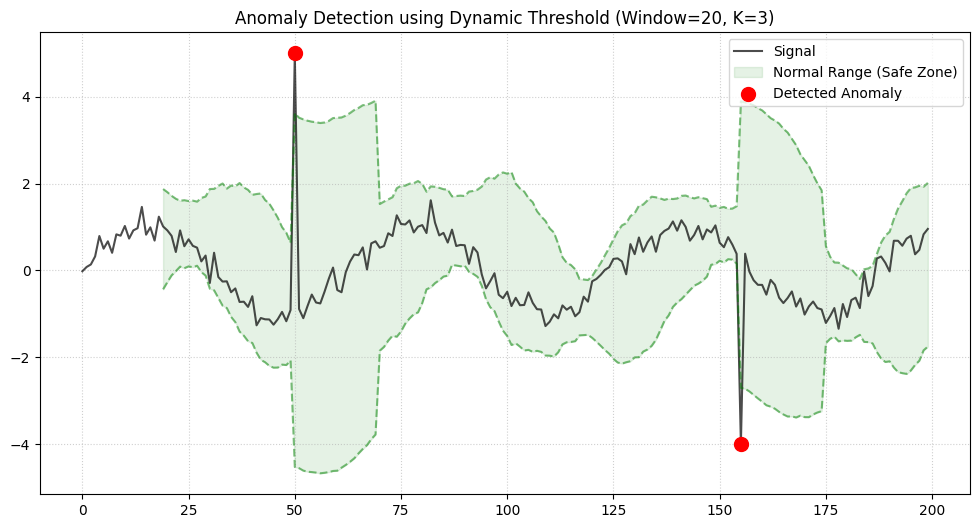

In [4]:
plt.figure(figsize=(12, 6))

# 1. 원본 신호
plt.plot(df.index, df['Signal'], label='Signal', color='black', alpha=0.7)

# 2. 볼린저 밴드 (정상 범위)
# fill_between: 두 선 사이를 색칠하는 함수
plt.fill_between(df.index, df['Upper_Band'], df['Lower_Band'], color='green', alpha=0.1, label='Normal Range (Safe Zone)')
plt.plot(df.index, df['Upper_Band'], linestyle='--', color='green', alpha=0.5) # 상한선 점선
plt.plot(df.index, df['Lower_Band'], linestyle='--', color='green', alpha=0.5) # 하한선 점선

# 3. 탐지된 이상치 (빨간 점)
plt.scatter(anomalies.index, anomalies['Signal'], color='red', s=100, label='Detected Anomaly', zorder=5)

plt.title(f"Anomaly Detection using Dynamic Threshold (Window={window_size}, K={k})")
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 해석:
# 초록색 영역은 환자의 평소 상태에 따라 구불구불하게 움직인다(Dynamic).
# 50번과 155번의 급격한 변화는 초록색 영역을 뚫고 나갔으므로 빨간 점(이상치)으로 탐지되었다.
# 반면, 작은 노이즈들은 초록색 영역 안에 있으므로 정상으로 간주되었다.

### 📝 실습 과제: 민감도(Sensitivity) 조절하기
헬스케어 분석가는 상황에 따라 알람의 민감도를 조절해야 한다.

1.  변수 `k` 값을 2로 낮춰본다. (기준을 완화)
2.  다시 코드를 실행했을 때 탐지되는 이상치의 개수는 늘어나는가, 줄어드는가?
3.  토론: 위급한 중환자실(ICU)에서는 K값을 낮게(민감하게) 잡아야 할까, 높게(둔감하게) 잡아야 할까? (정답은 없지만, 놓치면 안 되는 곳일수록 K를 낮추고 False Positive를 감수한다.)

In [5]:
# [실습 힌트]
# k = 2 로 변경 후 위의 시각화 코드 다시 실행
# K가 작아지면 'Normal Range(초록색 띠)'의 폭이 좁아진다.
# 따라서 밴드 밖으로 튀어나가는 점들이 더 많아지게 된다. (민감도 증가)